
Results for 20.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.793526  0.630919   0.743842  0.682743
1      Test  0.798039  0.603448   0.755396  0.670927
2  Original  0.836668  0.676316   0.830372  0.745468


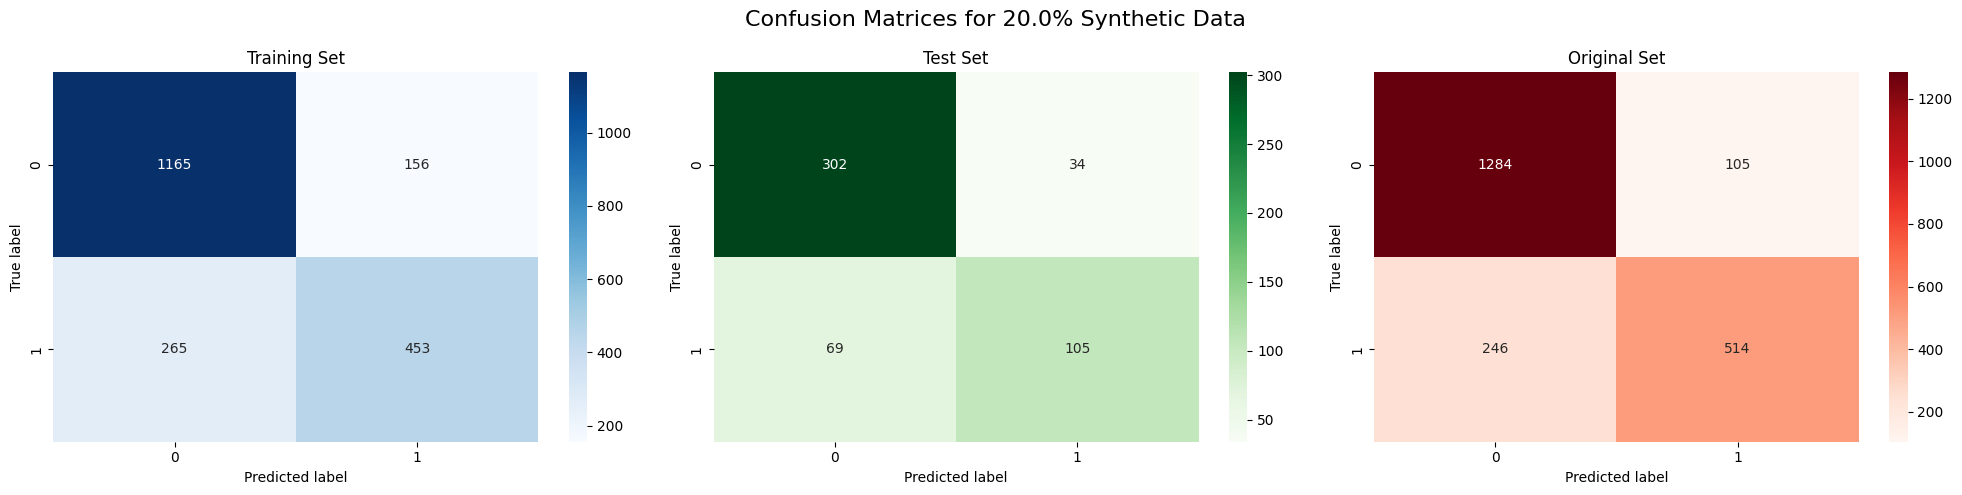

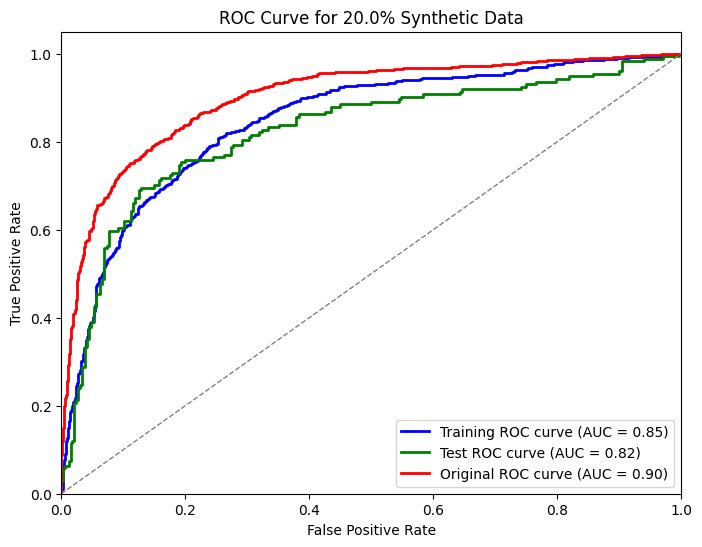


Results for 40.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.772361  0.558824   0.720379  0.629400
1      Test  0.718644  0.429268   0.642336  0.514620
2  Original  0.823639  0.610526   0.848263  0.710023


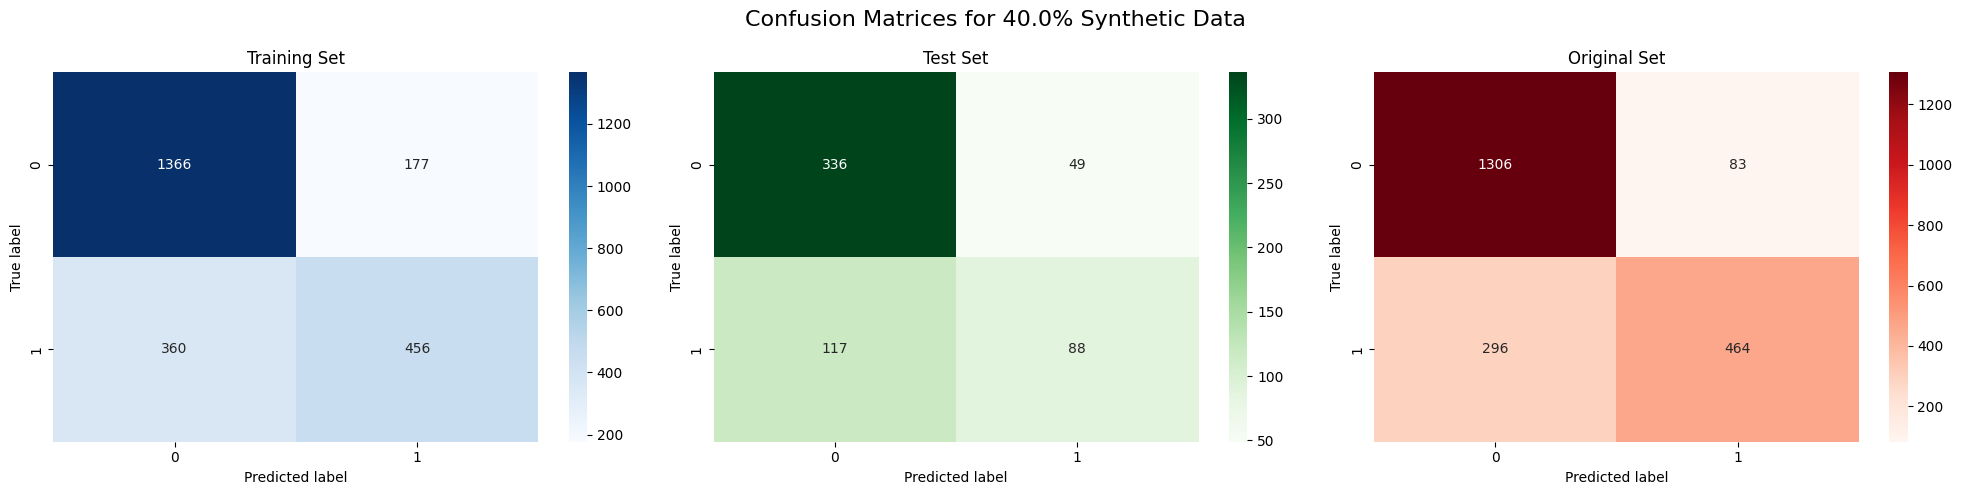

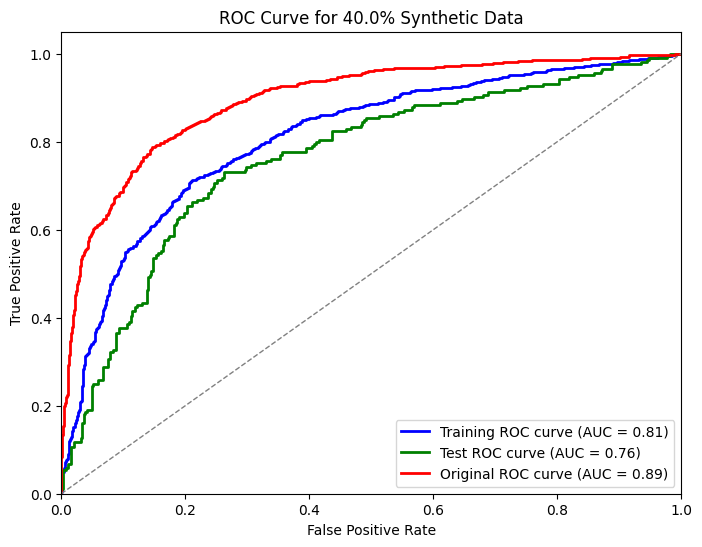


Results for 60.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.720791  0.431183   0.646774  0.517419
1      Test  0.770149  0.516588   0.677019  0.586022
2  Original  0.803164  0.539474   0.848861  0.659694


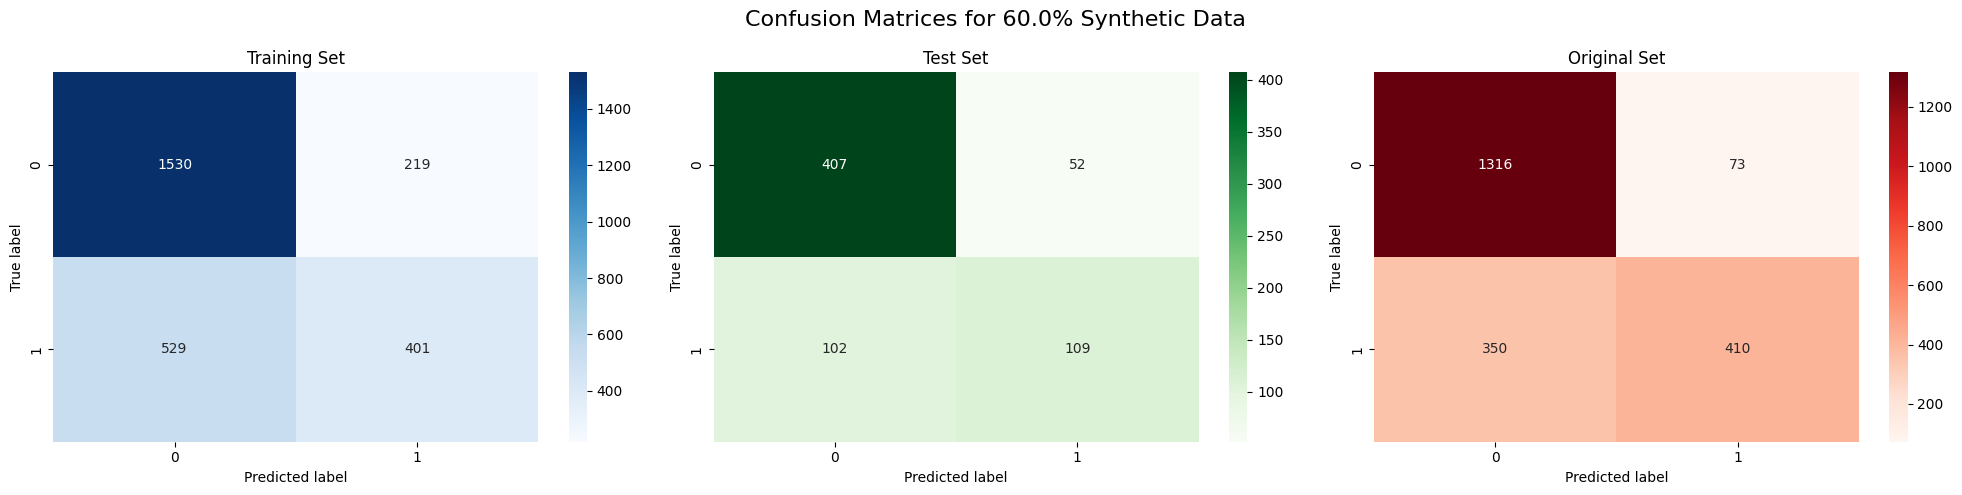

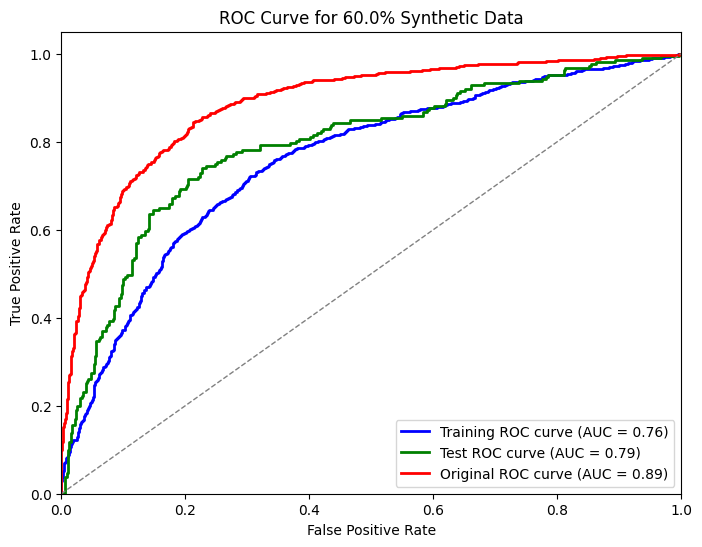


Results for 80.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.709903  0.393064   0.629630  0.483986
1      Test  0.728000  0.435294   0.649123  0.521127
2  Original  0.792462  0.513158   0.836910  0.636215


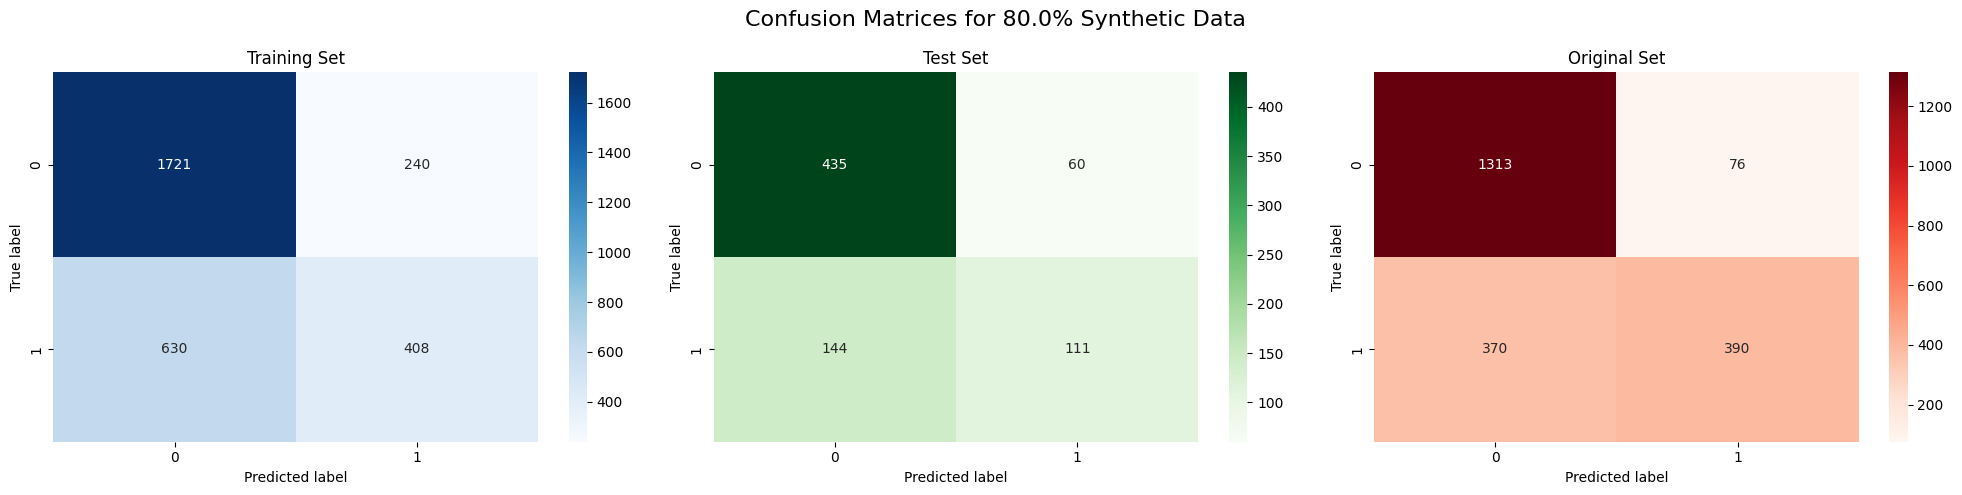

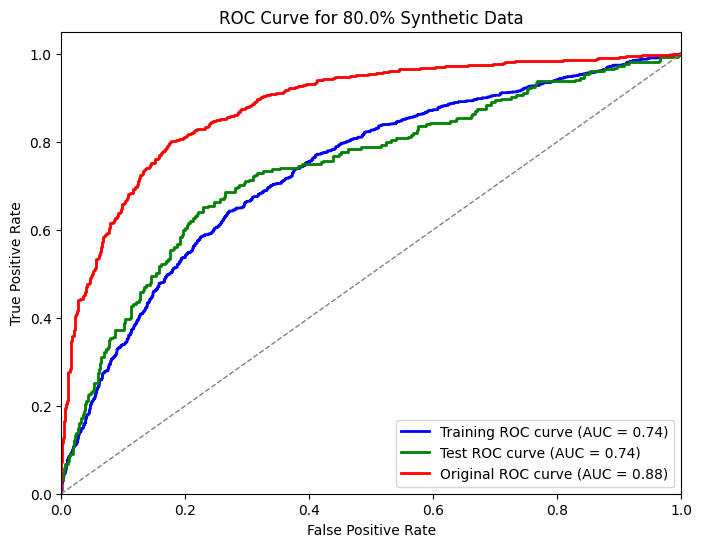


Results for 100.0% synthetic data:
    Dataset  Accuracy    Recall  Precision  F1-score
0  Training  0.693582  0.316578   0.597338  0.413833
1      Test  0.697590  0.347079   0.623457  0.445916
2  Original  0.773383  0.414474   0.882353  0.564011


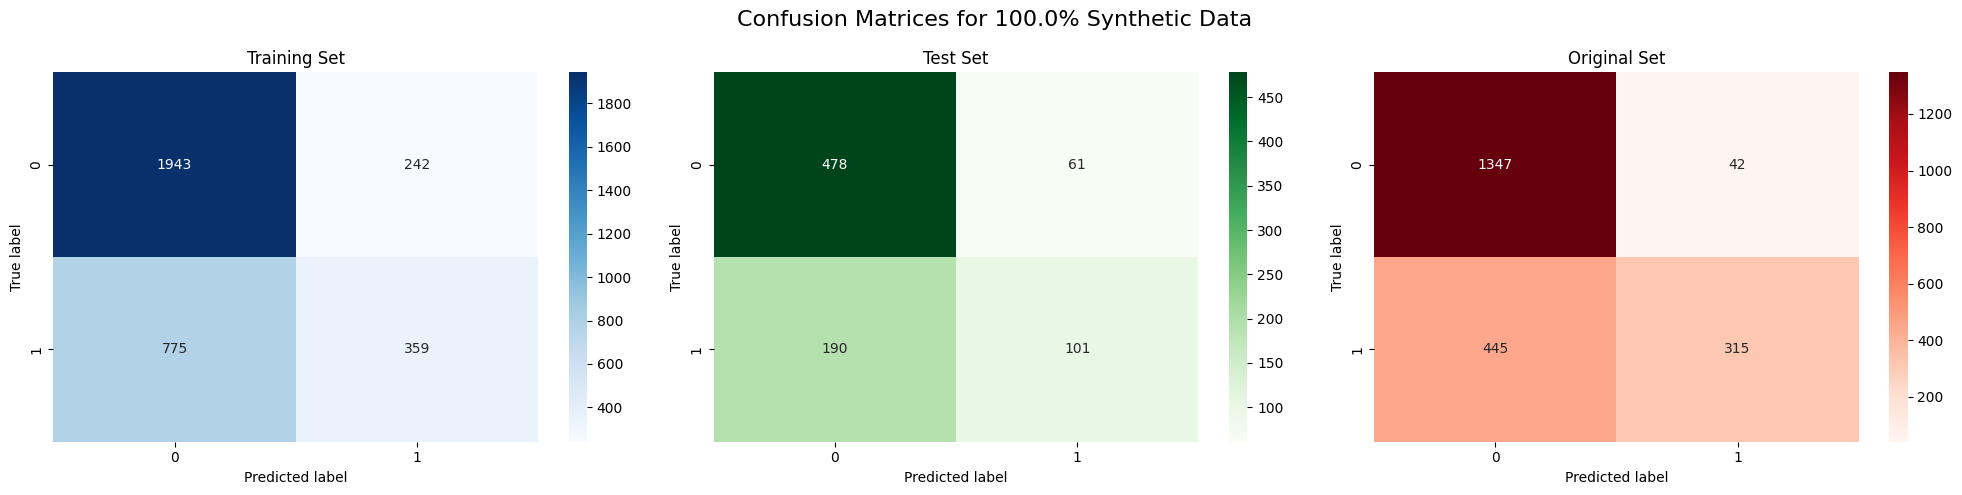

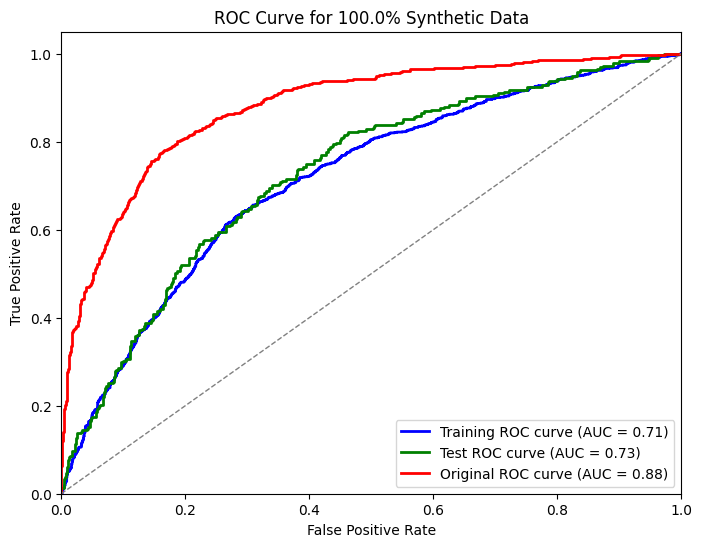

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle

# Load datasets
synthetic_data_path = '../datasets/tabular/generated/alzheimers_disease_genereted.csv'
synthetic_data = pd.read_csv(synthetic_data_path)

original_data_path = '../datasets/tabular/original/alzheimers_disease_data.csv'
original_data = pd.read_csv(original_data_path)

# Drop unnecessary columns
synthetic_data = synthetic_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')
original_data = original_data.drop(columns=['PatientID', 'DoctorInCharge'], errors='ignore')

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }

# Define percentages of synthetic data to use
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]  # Updated percentages

# Iterate through each percentage
for percentage in percentages:
    print(f"\nResults for {percentage*100}% synthetic data:")
    
    # Calculate number of synthetic samples to use
    n_synthetic = int(len(synthetic_data) * percentage)
    
    # Combine data
    combined_data = pd.concat([original_data, synthetic_data.iloc[:n_synthetic]], ignore_index=True)
    combined_data = shuffle(combined_data, random_state=42)
    
    # Prepare features and target
    X = combined_data.drop(columns=['Diagnosis'])
    y = combined_data['Diagnosis']

    # Manually split data to take the first 20% for testing
    split_point = int(0.2 * len(X))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = LogisticRegression(max_iter=3000)
    model.fit(X_train, y_train)
    
    # Calculate metrics for training set
    y_train_pred = model.predict(X_train)
    train_metrics = calculate_metrics(y_train, y_train_pred)
    
    # Calculate metrics for test set
    y_test_pred = model.predict(X_test)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # Calculate metrics for original dataset
    X_original = original_data.drop(columns=['Diagnosis'])
    y_original = original_data['Diagnosis']
    y_original_pred = model.predict(X_original)
    original_metrics = calculate_metrics(y_original, y_original_pred)
    
    # Create DataFrame with results
    results = pd.DataFrame({
        'Dataset': ['Training', 'Test', 'Original'],
        'Accuracy': [train_metrics['Accuracy'], test_metrics['Accuracy'], original_metrics['Accuracy']],
        'Recall': [train_metrics['Recall'], test_metrics['Recall'], original_metrics['Recall']],
        'Precision': [train_metrics['Precision'], test_metrics['Precision'], original_metrics['Precision']],
        'F1-score': [train_metrics['F1-score'], test_metrics['F1-score'], original_metrics['F1-score']]
    })
    
    # Print results
    print(results)
    
    # Plot confusion matrices
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    original_cm = confusion_matrix(y_original, y_original_pred)
    
    # Plot confusion matrices for current percentage
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Confusion Matrices for {percentage*100}% Synthetic Data', fontsize=16)
    
    datasets = ['Training', 'Test', 'Original']
    colors = ['Blues', 'Greens', 'Reds']
    
    for i, (cm, dataset) in enumerate(zip([train_cm, test_cm, original_cm], datasets)):
        sns.heatmap(cm, annot=True, fmt='d', cmap=colors[i], ax=axes[i])
        axes[i].set_title(f'{dataset} Set')
        axes[i].set_ylabel('True label')
        axes[i].set_xlabel('Predicted label')

    plt.tight_layout()
    plt.show()
    
    # Plot ROC curves
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Calculate ROC curve for training set
    y_train_prob = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    roc_auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
    
    # Calculate ROC curve for test set
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
    roc_auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
    
    # Calculate ROC curve for original dataset
    y_original_prob = model.predict_proba(X_original)[:, 1]
    fpr_original, tpr_original, _ = roc_curve(y_original, y_original_prob)
    roc_auc_original = auc(fpr_original, tpr_original)
    plt.plot(fpr_original, tpr_original, color='red', lw=2, label=f'Original ROC curve (AUC = {roc_auc_original:.2f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {percentage*100}% Synthetic Data')
    plt.legend(loc='lower right')
    plt.show()
